# Project Initializaion

# PC Price Predictions 

Author: Kaleb Nim

## Project Objective

> Build a Regression machine learning model to predict the computer 
price based on their configuration.

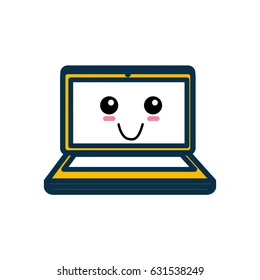

## Importing Libraries

In [29]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
# !pip install pyyaml==5.4.1
# !pip uninstall sklearn -y
# !pip install Cython
# !pip install -U scikit-learn
# !pip install phik

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

# EDA
import plotly.express as px
from sklearn.feature_selection import chi2, RFECV
import scipy.stats as ss
from pandas_profiling import ProfileReport
import phik
from phik import resources, report

# Evalutation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score ,mean_squared_log_error,mean_absolute_percentage_error

# Date preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer ,SimpleImputer ,IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler ,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, learning_curve ,cross_val_score ,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.svm import SVC

#Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR

## Load Dataset

In [31]:
df_raw = pd.read_csv('/content/drive/MyDrive/Datasets/pc_data (regression).csv')
df_raw

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,1706.40200
15316,15316,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,4000.10600
15317,15317,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,616.82600
15318,15318,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,2042.06600


## Data Dictonary

|     **Column**     	|                                **Description**                               	|
|:------------------:	|:----------------------------------------------------------------------------:	|
| Product ID        	| unique identifier ranging from 0 to 15319                                  	|
| Brand         	| Brand of the PC                                    	|
| Type            	| PC type, such as notebook, ultrabook     	|
| Screen Size          	| Size of the PC screen                     	|
| Screen Specs          	| PC screen specs with resolution                                                	|
| CPU     	| CPU infomation of the PC                            	|
|RAM             	| RAM information of the PC                             	|
| Hard Disk          	| Hard Disk information of the PC                  	|
|GPU:              	| Graphic card of the PC                        	|
|Operating System          	| Operating system, such as Windows 10, macOS               	|
|Weight:          	|  Weight of the PC             	|
| #**Price** 	| **PC price ($)** 	|

# Prevent Data Leakage 



> **Data leakage** is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.
Reference : [data-leakage-machine-learning](https://machinelearningmastery.com/data-leakage-machine-learning/)

To takle this problem I'll be creating a **Holdout Dataset** that will be left untouched in all data preprocessing and model training to act as a final sanity check of my finalizated model.


In [32]:
train_df,test_df = train_test_split(df_raw,test_size=0.2,random_state=1)
print(f'Shape of train_df:{train_df.shape}\nShape of test_df:{test_df.shape}')

Shape of train_df:(12256, 12)
Shape of test_df:(3064, 12)


# **Exploratory Data Analysis**

A good data science project starts from understanding our data. With that, I 
will perform some basic visualisation to spot some trends between features and target variable `Price ($)` and errors in the PC dataset.

---

To prevent the mutation of our original data, we will make a copy of our data to perform eda on it.

*EDA process will only be analysed to the train_df*

In [33]:
df_eda = train_df.copy()

## Descriptive Statistics

In [34]:
df_eda.shape

(12256, 12)

There are appriximately **12k** rows and **12** Features in the training factory datset

In [35]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12256 entries, 9909 to 13349
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        12256 non-null  int64  
 1   Brand             12256 non-null  object 
 2   Type              12256 non-null  object 
 3   Screen Size       12256 non-null  float64
 4   Screen Specs      12256 non-null  object 
 5   CPU               12256 non-null  object 
 6   RAM               12256 non-null  object 
 7   Hard Disk         12256 non-null  object 
 8   GPU               12256 non-null  object 
 9   Operating System  12256 non-null  object 
 10  Weight            12256 non-null  object 
 11  Price ($)         12256 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.2+ MB


It is to be noted that features:

Only `Product ID `, `Screen Size`, are **Quantitative** features

`Brand`, `Type`, `Screen Specs`, `CPU`,`RAM`, `Hard Disk`, `GPU`, `Operating System`, `Weight`, is a **nominally valued categorical** feature

`RAM`,`Screen Size` 

However Logic dictates that `Weight` Should also be a Quantitative feature
We will correct that during Feature Processing

In [36]:
descriptive_stats_Categorical = df_eda[['Brand', 'Type', 'Screen Specs', 'CPU','RAM', 'Hard Disk', 'GPU', 'Operating System']].describe().T
descriptive_stats_Categorical["Proportion of Most Frequent Value"] = descriptive_stats_Categorical["freq"] / len(df_eda) * 100
descriptive_stats_Categorical.sort_values("Proportion of Most Frequent Value", ascending=False)
descriptive_stats_Categorical


,count,unique,top,freq,Proportion of Most Frequent Value
Brand,12256,19,Lenovo,2835,23.131527
Type,12256,6,Notebook,6779,55.311684
Screen Specs,12256,40,Full HD 1920x1080,4760,38.83812
CPU,12256,118,Intel Core i5 7200U 2.5GHz,1792,14.62141
RAM,12256,9,8GB,5846,47.699086
Hard Disk,12256,39,256GB SSD,3899,31.81299
GPU,12256,110,Intel HD Graphics 620,2642,21.556789
Operating System,12256,9,Windows 10,10147,82.792102


In [37]:
descriptive_stats_Quantitative = df_eda.describe().T
descriptive_stats_Quantitative

,count,mean,std,min,25%,50%,75%,max
Product ID,12256.0,7667.742575,4414.394468,0.000,3851.750,7670.50,11487.250,15318.000
Screen Size,12256.0,15.003623,1.430442,10.100,14.000,15.60,15.600,18.400
Price ($),12256.0,3018.580203,1865.385002,463.536,1623.576,2624.24,3993.336,16259.336


### Get Number of Unique Values for each Feature

In [38]:
df_eda.nunique().sort_values()

Type                    6
RAM                     9
Operating System        9
Screen Size            18
Brand                  19
Hard Disk              39
Screen Specs           40
GPU                   110
CPU                   118
Weight                179
Price ($)            7861
Product ID          12256
dtype: int64

Even though 

Observations looking at most Most Frequent Values: 

*   No single value for any features
*   CPU is the most varied feature, with 118 unique values, extremely similar to GPU , with 110 unique values


*   Most PC types are: Notebook at 55%
*   Most PC runs on Windows 10 at 82%



## Using Pandas Profiling


In [39]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df_eda, title='Heart Disease', html={'style':{'full_width':True}})
# profile.to_notebook_iframe()
# # prof.to_file(output_file='mushroom_analysis.html')


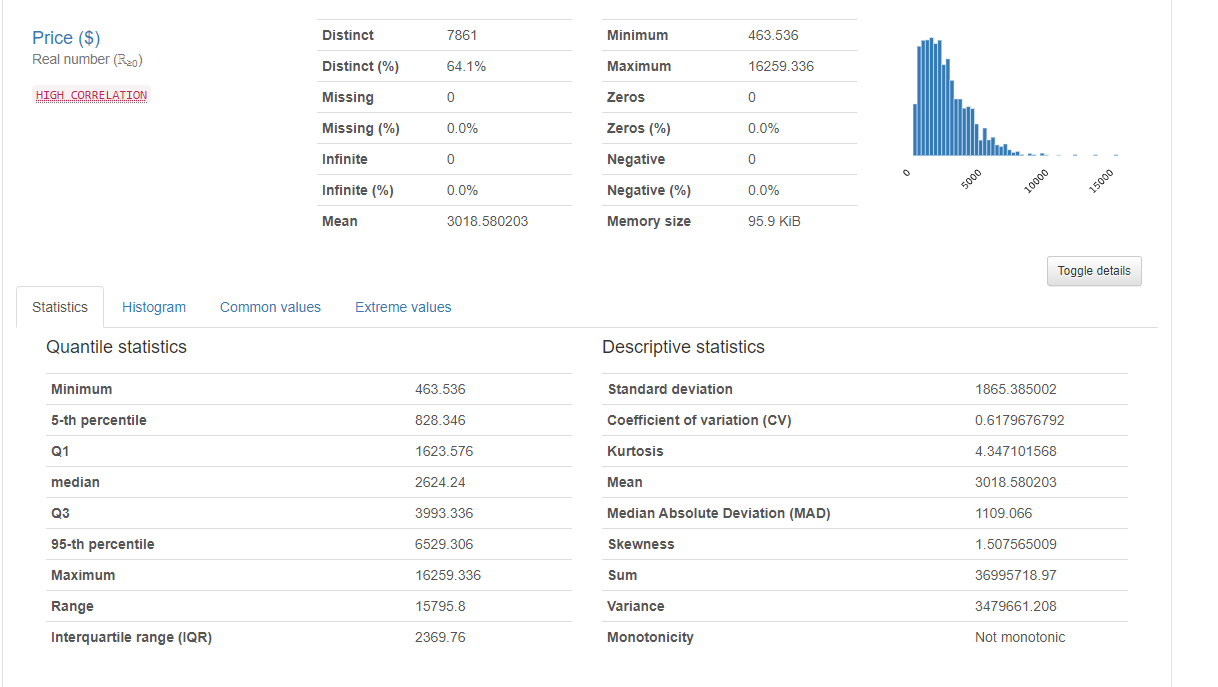

## Univariate Analysis

We are going to explore each variable in a data set, separately. Finding out counts of each value and central tendency of the values

## Target Variable Distribution: Price ($)

In [40]:
fig = px.histogram(df_eda, x="Price ($)",title="Distribution of PC Price ($)")
fig.show()

Data seems Highly Positively Skewed 

lets try a log scale

In [41]:
fig = px.histogram(df_eda, x="Price ($)",log_x=True ,title="Logarithmic distribution of PC Price ($) ")
fig.show()

## Quantitative Features Correlated to price

In [42]:
df_eda[['Weight','Screen Size','Price ($)']].corr().abs().sort_values("Price ($)", ascending=False)['Price ($)']


Price ($)      1.000000
Screen Size    0.072167
Name: Price ($), dtype: float64

## Identifying Null Values

In [43]:
percent_missing = df_eda.isnull().sum() * 100 / len(df_eda)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
Product ID,0.0
Brand,0.0
Type,0.0
Screen Size,0.0
Screen Specs,0.0
CPU,0.0
RAM,0.0
Hard Disk,0.0
GPU,0.0
Operating System,0.0


In [44]:
df_eda[['CPU']].head(30)

,CPU
9909,Intel Core i5 7200U 2.5GHz
893,Intel Core i5 7200U 2.5GHz
13745,Intel Core i5 6200U 2.3GHz
9240,Intel Core i7 8550U 1.8GHz
13686,Intel Core i5 7200U 2.5GHz
2248,AMD FX 8800P 2.1GHz
5889,Intel Core i5 7300HQ 2.5GHz
1930,Intel Core i5 7200U 2.5GHz
1562,Intel Core i7 7700HQ 2.8GHz
11837,Intel Core i7 8650U 1.9GHz


## Playing around with additional features

In [45]:
df_play = df_eda.copy()

In [46]:
df_play['CPU clock speed'] = df_play['CPU'].str.extract(r'\b(\w+)$', expand=True)
df_play

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($),CPU clock speed
9909,9909,Dell,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics,Windows 10,1.36kg,3932.3408,5GHz
893,893,Lenovo,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.32kg,4792.5360,5GHz
13745,13745,Toshiba,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,3901.0400,3GHz
9240,9240,Acer,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,1TB HDD,Nvidia GeForce MX130,Windows 10,2.2kg,1995.0800,8GHz
13686,13686,Lenovo,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.32kg,4804.1360,5GHz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,905,LG,Ultrabook,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.08kg,5591.7360,7GHz
5192,5192,Asus,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,Intel HD Graphics 520,Linux,2kg,1116.7600,2GHz
12172,12172,Dell,Gaming,15.6,Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,3.21kg,5465.4640,5GHz
235,235,Dell,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,AMD Radeon R7 M445,Linux,2.36kg,2394.9360,7GHz


In [47]:
df_play['CPU clock speed'] = df_play['CPU clock speed'].str.replace('GHz',"")
df_play['CPU clock speed'] = df_play['CPU clock speed'].astype('float64')

In [48]:
fig = px.histogram(df_play, x="CPU clock speed",title="Distribution of CPU clock speed")
fig.show()

In [49]:
df_play['CPU Brand'] = df_play['CPU'].str.extract(r'^([\w\-]+)', expand=True)
df_play['CPU Brand']

9909     Intel
893      Intel
13745    Intel
9240     Intel
13686    Intel
         ...  
905      Intel
5192     Intel
12172    Intel
235      Intel
13349    Intel
Name: CPU Brand, Length: 12256, dtype: object

In [50]:
df_play['CPU Brand'].value_counts()

Intel      11657
AMD          588
Samsung       11
Name: CPU Brand, dtype: int64

In [51]:
sns.countplot(data=df_play,x='CPU Brand')

Observations:

No Null Values in Dataset

## correlation categorical feature and target feature ( price )

In [52]:
# !pip install pingouin
#One way ANOVA test
import pingouin as pg
display(pg.anova(data=df_play, dv='Price ($)',between='CPU',
           ss_type=2, detailed=False, effsize='np2').round(3))

display(pg.anova(data=df_play, dv='Price ($)',between='CPU Brand',
           ss_type=2, detailed=False, effsize='np2').round(3))

display(pg.anova(data=df_play, dv='Price ($)',between='CPU clock speed',
           ss_type=2, detailed=False, effsize='np2').round(3))

display(pg.anova(data=df_play, dv='Price ($)',between='Brand',
           ss_type=2, detailed=False, effsize='np2').round(3))

display(pg.anova(data=df_play, dv='Price ($)',between='Type',
           ss_type=2, detailed=False, effsize='np2').round(3))

display(pg.anova(data=df_play, dv='Price ($)',between='GPU',
           ss_type=2, detailed=False, effsize='np2').round(3))

,Source,ddof1,ddof2,F,p-unc,np2
0,CPU,117,12138,185.041,0.0,0.641


,Source,ddof1,ddof2,F,p-unc,np2
0,CPU Brand,2,12253,218.807,0.0,0.034


,Source,ddof1,ddof2,F,p-unc,np2
0,CPU clock speed,14,12241,283.527,0.0,0.245


,Source,ddof1,ddof2,F,p-unc,np2
0,Brand,18,12237,134.923,0.0,0.166


,Source,ddof1,ddof2,F,p-unc,np2
0,Type,5,12250,1495.189,0.0,0.379


,Source,ddof1,ddof2,F,p-unc,np2
0,GPU,109,12146,178.416,0.0,0.616


## Phink correlation Metric smt smt just looking

In [53]:
df_play.phik_matrix()

interval columns not set, guessing: ['Product ID', 'Screen Size', 'Price ($)', 'CPU clock speed']


,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($),CPU clock speed,CPU Brand
Product ID,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031635,0.000000,0.000000,0.000000,0.000000
Brand,0.000000,1.000000,0.597209,0.603218,0.927760,0.932183,0.418201,0.778968,0.879613,0.832651,0.958597,0.548347,0.541387,0.456860
Type,0.000000,0.597209,1.000000,0.737250,0.789597,0.882506,0.536688,0.781918,0.922764,0.461405,0.917525,0.537503,0.206276,0.294732
Screen Size,0.000000,0.603218,0.737250,1.000000,0.848220,0.928761,0.567350,0.763425,0.895047,0.742318,0.977347,0.414711,0.507410,0.323772
Screen Specs,0.000000,0.927760,0.789597,0.848220,1.000000,0.975609,0.646719,0.843830,0.950989,0.896178,0.974360,0.741657,0.816515,0.890054
CPU,0.000000,0.932183,0.882506,0.928761,0.975609,1.000000,0.843644,0.969720,0.995509,0.946925,0.988415,0.880130,1.000000,1.000000
RAM,0.000000,0.418201,0.536688,0.567350,0.646719,0.843644,1.000000,0.804771,0.910983,0.306396,0.903041,0.702967,0.179334,0.417630
Hard Disk,0.000000,0.778968,0.781918,0.763425,0.843830,0.969720,0.804771,1.000000,0.933228,0.804659,0.966580,0.778609,0.806414,0.393669
GPU,0.000000,0.879613,0.922764,0.895047,0.950989,0.995509,0.910983,0.933228,1.000000,0.875883,0.990920,0.902956,0.486535,0.990603
Operating System,0.031635,0.832651,0.461405,0.742318,0.896178,0.946925,0.306396,0.804659,0.875883,1.000000,0.917641,0.289827,0.358029,0.330863


## Norminal or Ordinal Features?

In order to decide which features we should One-Hot-Encode(for Norminal features) and which features to Label Encode(for Ordinal features) 

For Each feature, we will be taking the Mean

# Problem currently facing: If i just one-hot-encode all categorical variables, ill end up with data with extremely high dimensions


Two ways i can go about solving

## Method 1 --> Indivisually spilt features 

CPU and GPU are features with the highest cardinility, 100+ unique values respectively ( details forgot lmao ) 

For CPU im tyring to seperate the different components and create new features

*  Brand: Intel 11657 AMD  588 Samsung 11
*  CPU clock speed E.g 2.88Ghz
*  Brand Modifier E.g i3,i5,i7

Also trying clustering GPU using some unsupervised learning models

[sklearn clustering](https://scikit-learn.org/stable/modules/clustering.html)

[Dimensional Reduction](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca)

## Method 2 --> Recursive Feature Elimination or like Random Forest Feature importance then take top 10

# Feature Processing

In [54]:
df = train_df.copy()

## Feature Selection


By performing feature selection on my data will allow me to accomplish the following:

*   Reduce Overfitting 

    Less redundant data means less opportunity to make decisions based on noise --> Improves Accuracy

*   Reduce the computational cost of modeling

    Less data means that algorithms train faster.


### Which features to select?

Based on above EDA, `ProductID` has a 0.00 correlation score and smt smt NOT DONE CUS ONLY REMOVE PRODUCT ID Therefore, we will remove both features and select the rest.

In [55]:
# Drop columns ProductID 
df = df.drop(['Product ID'], axis = 1) 

In [56]:
df.columns

Index(['Brand', 'Type', 'Screen Size', 'Screen Specs', 'CPU', 'RAM',
       'Hard Disk', 'GPU', 'Operating System', 'Weight', 'Price ($)'],
      dtype='object')

## Correcting Weight Datatype

I'll choose to keep RAM as a nominial categorical feature at the start. We will can change it later on idk fix this up

In [57]:
# Remvoe kg from Weight
df['Weight'] = df["Weight"].str.replace("kg","")

#Remove GB from RAM
df['RAM'] = df["RAM"].str.replace("GB","")

# Change Datatype from Object --> float64
df['Weight'] = df['Weight'].astype('float64')
df['RAM'] = df["RAM"].astype('int64')


In [58]:
fig, ax = plt.subplots(figsize = (12, 7), tight_layout = True)

sns.histplot(df, x="Weight", element="step",bins=10)


## Extracting Features, `X` and Target Variable, `y`

In [59]:
X = df.drop(columns=['Price ($)'])
y = df['Price ($)']

In [60]:
X

,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight
9909,Dell,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics,Windows 10,1.36
893,Lenovo,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,Windows 10,1.32
13745,Toshiba,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8,256GB SSD,Intel HD Graphics 520,Windows 7,1.20
9240,Acer,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8,1TB HDD,Nvidia GeForce MX130,Windows 10,2.20
13686,Lenovo,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,Windows 10,1.32
...,...,...,...,...,...,...,...,...,...,...
905,LG,Ultrabook,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,16,512GB SSD,Intel HD Graphics 620,Windows 10,1.08
5192,Asus,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4,256GB SSD,Intel HD Graphics 520,Linux,2.00
12172,Dell,Gaming,15.6,Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,16,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,3.21
235,Dell,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16,256GB SSD,AMD Radeon R7 M445,Linux,2.36


In [61]:
y

9909     3932.3408
893      4792.5360
13745    3901.0400
9240     1995.0800
13686    4804.1360
           ...    
905      5591.7360
5192     1116.7600
12172    5465.4640
235      2394.9360
13349     690.9200
Name: Price ($), Length: 12256, dtype: float64

### Train Test Split

We split our dataset into train and test set to better evaluate the performance of the model by examining its performance against the train set and test set.

This is to Check if Model if Overfitting, i.e Model performes will on trainig set but poorly on test set. Model is unalbe to generalize to new unseen data

In [62]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [63]:
print(X_train.shape,X_test.shape)

(9804, 10) (2452, 10)


## Feature Encoding

For Now we shall assume all features are norminally valued

We will look into other forms of encoding later on in this notebook or smt

Perfrom Dummy encoding for all categorical variables

In [64]:
categorical_col = ['Brand', 'Type', 'Screen Size', 'Screen Specs', 'CPU', 'Hard Disk', 'GPU', 'Operating System']

onehot_encode_train = pd.get_dummies(X_train[categorical_col], drop_first= False, prefix_sep="-") #onehot encode for categorical features

onehot_encode_test = pd.get_dummies(X_test[categorical_col], drop_first= False, prefix_sep="-") #onehot encode for categorical features

display(onehot_encode_train)
display(onehot_encode_test)

,Screen Size,Brand-Acer,Brand-Apple,Brand-Asus,Brand-Chuwi,Brand-Dell,Brand-Fujitsu,Brand-Google,Brand-HP,Brand-Huawei,...,GPU-Nvidia Quadro M620M,Operating System-Android,Operating System-Chrome OS,Operating System-Linux,Operating System-Mac OS X,Operating System-No OS,Operating System-Windows 10,Operating System-Windows 10 S,Operating System-Windows 7,Operating System-macOS
6962,15.6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3789,15.6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
285,15.6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
137,17.3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10991,11.6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12578,13.3,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3759,15.6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9515,17.3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10209,14.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,Screen Size,Brand-Acer,Brand-Apple,Brand-Asus,Brand-Chuwi,Brand-Dell,Brand-Fujitsu,Brand-Google,Brand-HP,Brand-Huawei,...,GPU-Nvidia Quadro M620,GPU-Nvidia Quadro M620M,Operating System-Chrome OS,Operating System-Linux,Operating System-Mac OS X,Operating System-No OS,Operating System-Windows 10,Operating System-Windows 10 S,Operating System-Windows 7,Operating System-macOS
12482,15.6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6135,15.6,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9044,12.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13025,15.6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14387,15.6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10620,15.6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3165,13.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12605,13.3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9468,13.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Observations:

The problem we will face is our data turns into one of **high dimensionally**. This is due to most features being a categorical variable, some with high cardinality ( `CPU`,`GPU` ).

This would result in the Curse of Dimensionality in which observations become harder to cluster SMT SMT
[Curse of Dimensionally](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e)


OK SO WE CAN TRY:


*   CPU Type group
*   Clustering for GPU using some sklearn library
* Extract Screen Size Width and Height
*  PCA ( find the drawback of using PCA )
* Recursive feature elimination


## Backward Elimination

As we have 322 features after encoding categorical features,we will make use of a process called backward elimination which will eliminates (removes) features from a dataset through a recursive feature elimination (RFE) process thus keeping only the important variables. 

Hence reducing dimiensionally of data

In [65]:
svm = SVC(kernel='linear') #LinearSVC
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svm, step=1, cv=5,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)
rfecv.fit(onehot_encode_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

ValueError: ignored

In [77]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(onehot_encode_train, y_train)

RandomForestRegressor(max_depth=10, random_state=1)

In [81]:
features = onehot_encode_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-12:]  # top 10 features
print([features[i] for i in indices])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

['Hard Disk-256GB SSD', 'Screen Specs-4K Ultra HD / Touchscreen 3840x2160', 'GPU-Nvidia GeForce GTX 1080', 'Brand-Razer', 'Type-Workstation', 'CPU-Intel Xeon E3-1535M v6 3.1GHz', 'GPU-Nvidia GeForce GTX 1070', 'Hard Disk-1TB SSD', 'Hard Disk-512GB SSD', 'Screen Specs-1366x768', 'Screen Size', 'Type-Notebook']


In [66]:
onehot_encode_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9804 entries, 6962 to 3955
Columns: 342 entries, Screen Size to Operating System-macOS
dtypes: float64(1), uint8(341)
memory usage: 3.3 MB


# YO YO LETS JUST TRY WITH THE TOP 10 features for randomforest and see how lmao

In [67]:
X_train = onehot_encode_train[['Hard Disk-256GB SSD', 'Screen Specs-4K Ultra HD / Touchscreen 3840x2160', 'GPU-Nvidia GeForce GTX 1080', 'Brand-Razer', 'Type-Workstation', 'CPU-Intel Xeon E3-1535M v6 3.1GHz', 'GPU-Nvidia GeForce GTX 1070', 'Hard Disk-1TB SSD', 'Hard Disk-512GB SSD', 'Screen Specs-1366x768', 'Screen Size', 'Type-Notebook']]
X_test = onehot_encode_test[['Hard Disk-256GB SSD', 'Screen Specs-4K Ultra HD / Touchscreen 3840x2160', 'GPU-Nvidia GeForce GTX 1080', 'Brand-Razer', 'Type-Workstation', 'CPU-Intel Xeon E3-1535M v6 3.1GHz', 'GPU-Nvidia GeForce GTX 1070', 'Hard Disk-1TB SSD', 'Hard Disk-512GB SSD', 'Screen Specs-1366x768', 'Screen Size', 'Type-Notebook']]
X_train

,Hard Disk-256GB SSD,Screen Specs-4K Ultra HD / Touchscreen 3840x2160,GPU-Nvidia GeForce GTX 1080,Brand-Razer,Type-Workstation,CPU-Intel Xeon E3-1535M v6 3.1GHz,GPU-Nvidia GeForce GTX 1070,Hard Disk-1TB SSD,Hard Disk-512GB SSD,Screen Specs-1366x768,Screen Size,Type-Notebook
6962,0,0,0,0,0,0,0,0,0,0,15.6,0
3789,0,0,0,0,0,0,0,0,0,1,15.6,1
285,0,0,0,0,0,0,0,0,0,0,15.6,1
137,0,0,0,0,0,0,0,0,0,0,17.3,0
10991,0,0,0,0,0,0,0,0,0,1,11.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12578,0,0,0,0,0,0,0,0,0,0,13.3,1
3759,0,0,0,0,0,0,0,0,0,0,15.6,1
9515,0,0,0,0,0,0,1,0,0,0,17.3,0
10209,0,0,0,0,0,0,0,0,0,1,14.0,1


In [70]:
y_test

12482     722.53168
6135     1468.40800
9044     4033.04000
13025    4004.93600
14387    2934.50600
            ...    
10620    6519.05000
3165     4686.93688
12605    3675.25600
9468     2538.53600
15071    6011.42600
Name: Price ($), Length: 2452, dtype: float64

In [75]:
# Utility Function 
def quick_evalutaion(models, X_train, X_test, y_train, y_test,metrics=["r2","neg_mean_absolute_error","neg_mean_squared_log_error","neg_mean_absolute_percentage_error"],curve = True, cv = KFold(n_splits=5,shuffle=True,random_state=1)):
    hist = {}
    
    for idx, model in (enumerate(models)):
        try:
            clf = model(random_state=42,max_iter=300,class_weight='balanced') # Setting random_state for certain model + set class rate to balanced 
        except:
            clf = model()
        clf.fit(X_train, y_train)
        test_prediction = clf.predict(X_test) # Testing on validation dataset

        MAPE_test = mean_absolute_percentage_error(y_test, test_prediction)
        MAE_test = mean_absolute_error(y_test, test_prediction)
        MSLE_test = mean_squared_log_error(y_test, test_prediction)

        # 5-Fold CV
        cv_hist = cross_validate(clf, X_train, y_train, scoring=metrics,verbose=1)

        # Record down the performance
        hist[model.__name__] = dict(
            # train_acc = acc_train,
            cv_r2 = cv_hist['test_r2'].mean(),
            cv_MAE = cv_hist['test_neg_mean_absolute_error'].mean(),
            cv_MSLE = cv_hist['test_neg_mean_squared_log_error'].mean(),
            cv_MAPE = cv_hist['test_neg_mean_absolute_percentage_error'].mean(),
            MAE_test_score = MAE_test,
            MSLE_test_score =MSLE_test,
            MAPE_test_score = MAPE_test
            
        )

        # Plotting the learning Curve of each Model using: neg_mean_squared_log_error
        if curve:
          fig, ax = plt.subplots(figsize=(10, 8))
          train_sizes = np.linspace(.1, 1.0, 10)
          train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring="neg_mean_squared_log_error")
          scores = pd.DataFrame({
          "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
          "Train Scores" : train_scores.flatten(),
          "Test Scores" : test_scores.flatten()
          }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
          # print(f"THis is train_sizes:\n{train_sizes}\n This is train_scores:\n{train_scores}\n This is test_scores:{test_scores}")
          sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
          ax.set_title(f"Learning Curve of {model}")
          ax.set_ylabel("f1_score")
          ax.set_xlabel("Train Sizes")
          plt.show()
        
    # plt.tight_layout()
    display(pd.DataFrame(hist).T)
    # plt.show()

In [80]:
models = [DummyRegressor,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor,LinearSVR]

quick_evalutaion(models, X_train, X_test, y_train, y_test, curve=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

,cv_r2,cv_MAE,cv_MSLE,cv_MAPE,MAE_test_score,MSLE_test_score,MAPE_test_score
DummyRegressor,-0.000460,-1435.093284,-0.422279,-0.720243,1406.315145,0.414500,0.710594
LinearRegression,0.667996,-818.060516,-0.156397,-0.355454,808.998966,0.159268,0.358153
DecisionTreeRegressor,0.763020,-666.881456,-0.113852,-0.286203,659.198593,0.114770,0.287969
RandomForestRegressor,0.763010,-667.285771,-0.113851,-0.286276,659.305231,0.114706,0.287884
ExtraTreesRegressor,0.763020,-666.881456,-0.113852,-0.286203,659.198593,0.114770,0.287969
GradientBoostingRegressor,0.746907,-707.276783,-0.120413,-0.302604,697.518485,0.121080,0.303215
HistGradientBoostingRegressor,0.747796,-699.622944,-0.116064,-0.293238,681.197676,0.115940,0.292766
LinearSVR,0.329528,-1058.374393,-0.207624,-0.405282,1010.801124,0.197551,0.397586
